<a href="https://colab.research.google.com/github/manuelcastiblan/NaturalLanguageProcessing/blob/main/NLP_Whats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Primer trabajo de procesamiento de lenguaje natural**
##Manuel Elkin Castiblanco Briceño
###Este trabajo analizará un chat de WhatsApp, el escogido fue el chat de un grupo familiar. 
###El presente Notebook, tendrá distintas partes, debido al procesamiento, limpieza y análisis de los datos

Se instalan las librerias a usar

---



In [1]:
!python -m pip install --upgrade pip
!pip install numpy --upgrade --quiet
!pip install pandas --upgrade --quiet
!pip install matplotlib --upgrade --quiet
!pip install seaborn --upgrade --quiet
!pip install wordcloud --upgrade --quiety
!pip install emoji  --upgrade --quiet
!pip install plotly_express --upgrade --quiet
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: matplotlib 3.5.3
Uninstalling matplotlib-3.5.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.3-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (Y/n)? y
  Successfully uninstalled matplotlib-3.5.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x8

Se cargan las librerias

In [2]:
import os, re, string
import nltk
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import emoji
from collections import Counter
import plotly.express as px
from datetime import *
import datetime as dt

##La siguiente función realiza la carga del archivo txt que contiene el chat de whatsapp seleccionado. Esta función sirve especificamente para chats exportados de iOS. Se guardan los datos de nombre de usuario, mensajes, y fecha-hora

In [3]:
def chatTodf(txt_file):
    '''Funcion para cargar chat de WhatsApp exportado de iOs'''
    with open(txt_file,encoding='utf-8') as file:
        data = file.read()
        data = data.splitlines()

    usuario     = [] 
    mensaje  = [] 
    datetime = []
    
    for row in data:
        try:
            str_date = re.findall(r'\[.*?\]', row)[0]
            datetime.append(str(str_date)[1:-1].strip())
        except:
            datetime.append('')
        try:
            s = re.search('] (.*?):', row).group(1)
            usuario.append(s)
        except:
            usuario.append('')
        try:
            mensaje.append(row.split(': ', 1)[1])
        except:
            mensaje.append('')

    df = pd.DataFrame(zip(datetime, usuario, mensaje), columns=['datetime', 'usuario', 'mensaje'])
    df = df[df.usuario != ''].reset_index(drop=True)
    
    return df

whatsapp_df = chatTodf('_chat4.txt')

###A continuación se limpia el dato de fecha, para poder convertir los datos de la columna a formato datetime soportado por pandas

In [4]:
whatsapp_df['datetime'] = whatsapp_df['datetime'].str.replace('.','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [5]:
whatsapp_df['datetime'] = pd.to_datetime(whatsapp_df.datetime, format='%d/%m/%y, %I:%M:%S %p')


###Se realiza una limpieza de datos adicional, eliminando las filas que contengan imagenes, videos, stickers, gif o audios

In [84]:
whatsapp_df = whatsapp_df.drop(whatsapp_df[whatsapp_df['mensaje'] == "‎sticker omitido"].index)
whatsapp_df = whatsapp_df.drop(whatsapp_df[whatsapp_df['mensaje'] == "‎imagen omitida"].index)
whatsapp_df = whatsapp_df.drop(whatsapp_df[whatsapp_df['mensaje'] == "‎GIF omitido"].index)
whatsapp_df = whatsapp_df.drop(whatsapp_df[whatsapp_df['mensaje'] == "‎audio omitido"].index)
whatsapp_df = whatsapp_df.drop(whatsapp_df[whatsapp_df['mensaje'] == "\u200evideo omitido"].index)



A continuación se identifican los usuarios presentes en el chat, se muestra el nombre de cada uno de ellos y el total de usuarios                       

In [85]:
usuarios = whatsapp_df.usuario.unique()
is_group = True

if is_group:
    usuarios = np.delete(usuarios, 0)
    
print('Nombre de los usuarios presentes en el chat:', usuarios)
print('Total de usuarios:', len(usuarios)) 

Nombre de los usuarios presentes en el chat: ['Tía Fanny' 'Karen Quiroga' 'Tia Mercedes' 'Claudia Tía' 'Tío Ricardo'
 'Blanca' 'Jeimy Ospina' 'Rocio Tia' 'Andrea Montenegro' 'Juan David'
 'Leo' 'Manuel Castiblanco' 'Hernando Buitrago' 'Mamá' 'Tatis😏']
Total de usuarios: 15


### Se realiza una agrupación de datos por usuarios y número de mensajes

In [86]:
usuario_df = whatsapp_df.groupby('usuario')['mensaje'].count().sort_values(ascending=False).reset_index()
if is_group:
    usuario_df.drop(index=11, axis=0, inplace=True)

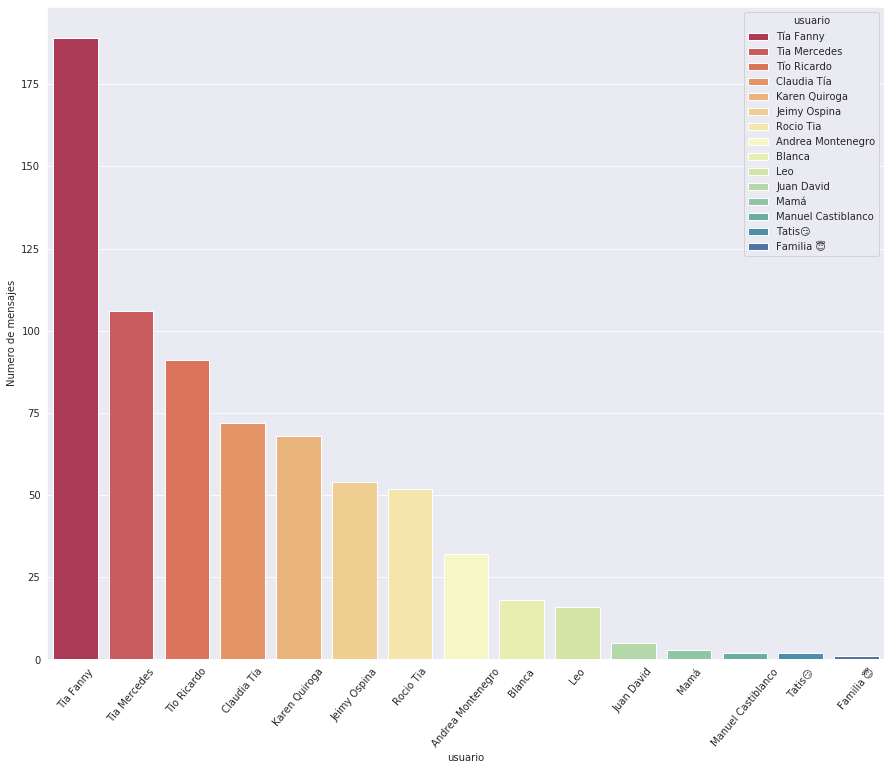

In [87]:
sns.set_style('darkgrid')
matplotlib.rcParams['figure.figsize'] = (15, 12)

#plt.title("Most active users in conversation")
barplot = sns.barplot(data=usuario_df, x="usuario", y="mensaje", hue="usuario", palette="Spectral", dodge=False)
barplot.set_xticklabels(rotation=50, labels=usuario_df.usuario)
plt.ylabel("Numero de mensajes")
plt.show()

###Ahora se identifico la fecha de inició del chat y la fecha de fin.

In [88]:
start = whatsapp_df.datetime.min()
end = whatsapp_df.datetime.max()

difference = end-start
print("La fecha de inicio del chat va desde {} hasta {}".format(start, end))
print("Aproximadamente se encuentran {} horas".format(difference))

La fecha de inicio del chat va desde 2016-04-17 22:30:09 hasta 2022-08-10 18:31:04
Aproximadamente se encuentran 2305 days 20:00:55 horas


In [89]:
difference.to_timedelta64()
average = whatsapp_df.shape[0]/difference.days
print("Numero promedio de mensajes por dia: {}".format(int(average)))

Numero promedio de mensajes por dia: 0


### En esta parte se identificaron las horas del día en las que el chat se encuentra más activo

In [90]:
whatsapp_df1 = whatsapp_df.copy()
whatsapp_df1["horas"] = whatsapp_df['datetime'].apply(lambda x: x.hour)
times_df = whatsapp_df1.groupby('horas').count().reset_index().sort_values(by = 'horas')

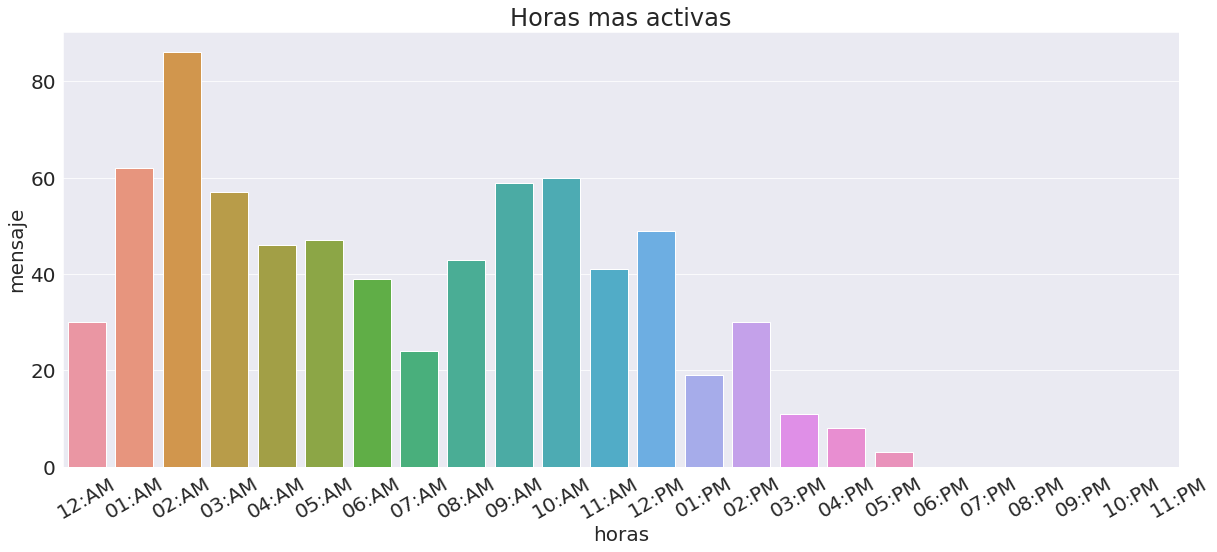

In [91]:
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (20, 8)
sns.set_style("darkgrid")

plt.title('Horas mas activas');
time_plot = sns.barplot(x="horas",y="mensaje",data = times_df,dodge=False)
labels=["12:AM","01:AM","02:AM","03:AM","04:AM","05:AM","06:AM","07:AM","08:AM","09:AM","10:AM","11:AM","12:PM","01:PM","02:PM","03:PM","04:PM","05:PM","06:PM","07:PM","08:PM","09:PM","10:PM","11:PM"]
plt.xticks([i for i in range(24)], labels=labels, rotation=30)
plt.show()

###Siguendo la linea de lo anterior, se identificó la actividad durante los meses

In [92]:
whatsapp_df2 = whatsapp_df.copy()

whatsapp_df2["mes"] = whatsapp_df["datetime"].apply(lambda x: x.month)

months_df = whatsapp_df2.groupby("mes")["mensaje"].count().sort_values(ascending=False).reset_index()

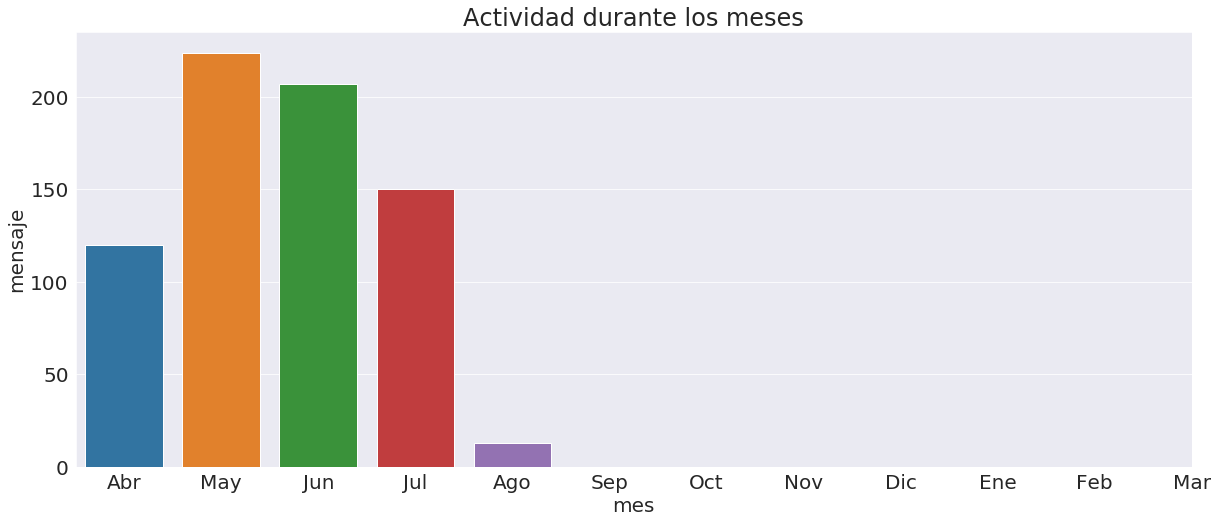

In [123]:
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (20, 8)
sns.set_style("darkgrid")

plt.title('Actividad durante los meses');

month_plot = sns.barplot(x="mes", y="mensaje", data=months_df)
labels = [ "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic","Ene", "Feb", "Mar"]
plt.xticks(ticks=[i for i in range(12)], labels=labels, rotation=0)
plt.show()

###Por otro lado en esta sección se buscó identificar el uso de emojis en el chat de la familia, y su distribución de uso

In [94]:
whatsapp_df3 = whatsapp_df.copy()

emoji_counter = Counter()
emoji_list = list(emoji.EMOJI_DATA.keys())
r = re.compile('|'.join(re.escape(p) for p in emoji_list))
#print(r)
for idx, row in whatsapp_df3.iterrows():
    found = r.findall(row["mensaje"])
    for emojif in found:
        emoji_counter[emojif] += 1

In [95]:
emojis_df = pd.DataFrame()
emojis_df['emoji'] = [''] * 10
emojis_df['numero_de_emoji'] = [0] * 10

i = 0
for item in emoji_counter.most_common(10):
    emojis_df.emoji[i] = item[0]
    emojis_df.numero_de_emoji[i] = int(item[1])
    i += 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [96]:
fig = px.pie(emojis_df, values='numero_de_emoji', names='emoji',title='Porcentaje de emojis usados en el chat')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

###En este punto se retomo de nuevo, la distrubición de los mensajes en el tiempo, y se identifico la actividad por días de la semana

In [97]:
weeks = {
0 : 'Lunes',
1 : 'Martes',
2 : 'Miercoles',
3 : 'Jueves',
4 : 'Viernes',
5 : 'Sabado',
6 : 'Domingo'
}
whatsapp_df['Dia'] = whatsapp_df['datetime'].dt.weekday.map(weeks)
whatsapp_df = whatsapp_df[['datetime','Dia','usuario','mensaje']]
whatsapp_df['Dia'] = whatsapp_df['Dia'].astype('category')
whatsapp_df.head()
whatsapp_df['Letra''s'] = whatsapp_df['mensaje'].apply(lambda s : len(s))
whatsapp_df['Palabra''s'] = whatsapp_df['mensaje'].apply(lambda s : len(s.split(' ')))
URLPATTERN = r'(https?://S+)'
whatsapp_df['Url_Count'] = whatsapp_df.mensaje.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(whatsapp_df.Url_Count)
whatsapp_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

,datetime,Dia,usuario,mensaje,Letras,Palabras,Url_Count
0,2016-04-17 22:30:09,Domingo,Familia 😇,‎Los mensajes y las llamadas están cifrados de...,143,23,0
1,2022-04-12 07:38:37,Martes,Tía Fanny,"Con mucho gusto Manuelito, lo quiero mucho😘😘 u...",68,10,0
2,2022-04-12 07:38:55,Martes,Karen Quiroga,❤️,2,1,0
15,2022-04-12 12:14:36,Martes,Tia Mercedes,Segundo día de caminata. Más dura que ayer. Lo...,52,9,0
16,2022-04-12 12:20:41,Martes,Tía Fanny,Muy bien 👍👏👏👏🌹💐🎊,16,3,0
...,...,...,...,...,...,...,...
968,2022-08-10 17:47:09,Miercoles,Tia Mercedes,Mejor dicho llego el entretenimiento.,37,5,0
969,2022-08-10 18:01:38,Miercoles,Tía Fanny,🤣🤣🤣🫣☺️,6,1,0
970,2022-08-10 18:10:50,Miercoles,Claudia Tía,"Y parece ser bien juicioso, le gusta el estud...",90,17,0
971,2022-08-10 18:11:27,Miercoles,Tía Fanny,🤣👍🤝,3,1,0


In [98]:
dias_list = whatsapp_df.Dia.unique()
for i in range(len(dias_list)):
  req_whatsapp_df = whatsapp_df[whatsapp_df["Dia"] == dias_list[i]]
  print(dias_list[i],'  ->  ',req_whatsapp_df.shape[0])

Domingo   ->   159
Martes   ->   68
Miercoles   ->   117
Lunes   ->   96
Sabado   ->   107
Jueves   ->   71
Viernes   ->   96


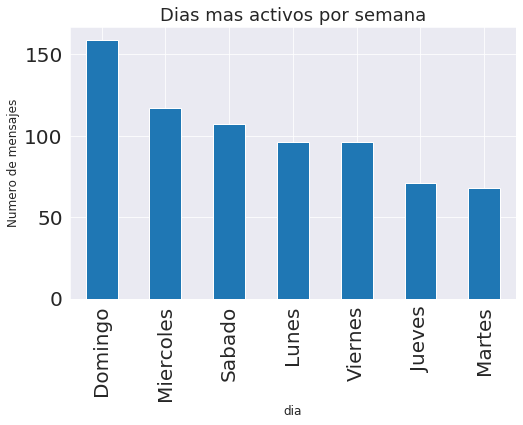

In [99]:
plt.figure(figsize=(8,5))
dias_activos = whatsapp_df['Dia'].value_counts()
a_d = dias_activos.head(10)
a_d.plot.bar()
plt.xlabel('dia',fontdict={'fontsize': 12,'fontweight': 10})
plt.ylabel('Numero de mensajes',fontdict={'fontsize': 12,'fontweight': 10})
plt.title('Dias mas activos por semana',fontdict={'fontsize': 18,'fontweight': 8})
plt.show()

### Siguendo lo anterior, se decidió realizar una serie de tiempo, con el número de los mensajes enviados, esto tratando de ver de otra forma la actividad por meses y años

In [100]:
whatsapp_df['fecha'] =  pd.to_datetime(whatsapp_df['datetime']).dt.date

In [101]:
z = whatsapp_df['fecha'].value_counts() 
z1 = z.to_dict() #converts to dictionary
whatsapp_df['mensajes_count'] = whatsapp_df['fecha'].map(z1)
### Timeseries plot 
fig = px.line(x=whatsapp_df['fecha'],y=whatsapp_df['mensajes_count'])
fig.update_layout(title='Serie de tiempo de numero de mensajes.',
                  xaxis_title='Mes',
                  yaxis_title='Numero de mensajes')
fig.update_xaxes(nticks=20)
fig.show()

##Ahora para el análisis se utilizará NLTK y Spacy

In [102]:
nltk.download("punkt")
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [103]:
spacy.cli.download("es")
nlp=spacy.load("es_core_news_sm")

⚠ As of spaCy v3.0, shortcuts like 'es' are deprecated. Please use the
full pipeline package name 'es_core_news_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


### Se cargan los stop Words, se limpia el set de datos y se tokenizan los datos de texto. Se realizó una tokenización usando NLTK, así mismo se realizó la lematización usando NLTK

In [104]:
nltk.download("stopwords")
from nltk.corpus import stopwords
misstop=stopwords.words("spanish")+["á","Y"]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [105]:
whatsapp_df['words_tokenize'] = whatsapp_df.apply(lambda row: nltk.word_tokenize(row['mensaje'],language='spanish'), axis=1)

In [106]:
whatsapp_df['words_tokenize'] = whatsapp_df.apply(lambda row: nltk.Text(row['words_tokenize']),axis=1)

In [107]:
whatsapp_df['words_tokenize'] = whatsapp_df['words_tokenize'].apply(lambda x: [item for item in x if item not in misstop])

In [108]:
whatsapp_df['words_tokenize'] = whatsapp_df['words_tokenize'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))


In [109]:
wordnet_lem = WordNetLemmatizer()

whatsapp_df['words_tokenize'] = whatsapp_df['words_tokenize'].apply(wordnet_lem.lemmatize)

In [110]:

whatsapp_df['words_tokenize'] = whatsapp_df['words_tokenize'].str.lower()

In [111]:
all_words = ' '.join([word for word in whatsapp_df['words_tokenize']])


## Este Wordcloud nos muestra las palabras más usadas en el chat, y se puede apreciar que resaltan las palabras "Buenos días", "Familia, "Feliz Cumpleaños", "Dios", entre otras. 

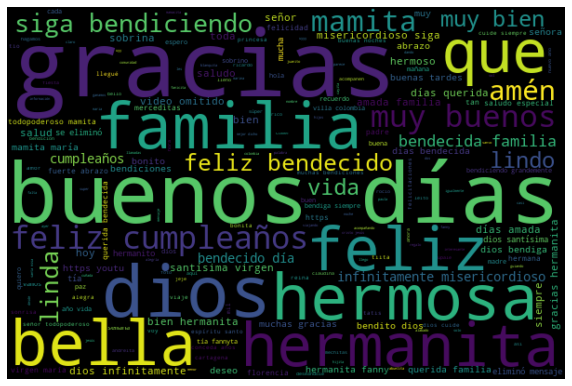

In [112]:
%matplotlib inline


wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

##Ahora creamos un libro en Spacy, dónde se identifican las partes del discurso

In [113]:
doc=nlp(''.join(str(whatsapp_df['words_tokenize'].tolist())))


In [114]:
partes=[]
for x in range(1,len(doc)):
    partes.append([doc[x].text, doc[x].lemma_,doc[x].pos_, doc[x].tag_, doc[x].ent_type_,doc[x].is_stop])
partes[100:150]

[['muy', 'mucho', 'ADV', 'ADV', '', True],
 ['guapas', 'guapo', 'ADJ', 'ADJ', '', False],
 ['cuñadas', 'cuñada', 'ADJ', 'ADJ', '', False],
 ['subiendo', 'subir', 'VERB', 'VERB', '', False],
 ['cuesta', 'costar', 'VERB', 'VERB', '', False],
 ['arriba', 'arriba', 'ADV', 'ADV', '', True],
 ["'", "'", 'SYM', 'SYM', '', False],
 [',', ',', 'PUNCT', 'PUNCT', '', False],
 ["'", "'", 'SYM', 'SYM', '', False],
 ['jeje', 'jeje', 'VERB', 'VERB', '', False],
 ["'", "'", 'SYM', 'SYM', '', False],
 [',', ',', 'PUNCT', 'PUNCT', '', False],
 ["'", "'", 'SYM', 'SYM', '', False],
 ['tienen', 'tener', 'VERB', 'VERB', '', True],
 ['buen', 'buen', 'ADJ', 'ADJ', '', True],
 ['físico', 'físico', 'NOUN', 'NOUN', '', False],
 ['hermanas', 'hermana', 'ADJ', 'ADJ', '', False],
 ['👍', '👍', 'PUNCT', 'PUNCT', '', False],
 ['💪', '💪', 'SPACE', 'SPACE', '', False],
 ['👏', '👏', 'PROPN', 'PROPN', '', False],
 ["'", "'", 'SYM', 'SYM', '', False],
 [',', ',', 'PUNCT', 'PUNCT', '', False],
 ["'", "'", 'SYM', 'SYM', '', Fal

###Se identificaron los nombres propios, y se realizó una nube de palabras con estos

In [115]:
nombres=[item[0] for item in partes if item[2]=="NOUN" and not item[5]]
print(set(nombres))


{'semana', 'regalos', 'hermano', 'bendiciendo', 'fotografa', 'villa', 'espacio', '♀', 'misericordia', 'quedo', 'hermosísima', 'sedes', 'reporto', '💐', 'upale', 'abril', 'hombre', 'gato', 'andre', 'camino', 'niñas', '🏻', 'niña', 'princesas', '🍬', 'música', 'alegría', 'uyyy', 'teléfono', 'actitud', 'palabra', 'manejo', 'escucharlos', 'mensajes', 'destino', 'distancia', 'físico', '😜', 'ramo', 'mamacita', 'información', 'ahhh', 'tardes', '😘', '💖', 'coquitos', 'mamita', 'éxitos', '\\u200evideo', 'padres', 'contribuyentes', '💓', 'nuncia', 'noches', 'kilómetro', 'proyecto', '\\u200elos', 'avances', 'canciones', 'k=1', "'", 'lluvia', '🤗', 'bendito', 'señor', 'juegos', 'ok', 'fotos', 'nietos', 'foto', 'sol', 'juanito', 'sábado', 'caragena', 'felicitaciines', '😉', '3124911906', '🌹', 'colegios', 'tiito', 'gracias', 'sonrisa', 'visita', '🙄', 'unión', 'coronilla', 'encanto', 'reinas', 'labor', 'mañana', 'premio', 'bellassss', 'madresita', 'lr1u8gkhlaw', 'play', 'fannyta', 'derecho', 'labores', 'ant

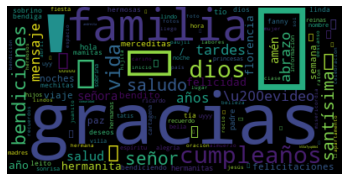

None

In [116]:
nombresspacy=pd.DataFrame(nombres)
contaname=pd.value_counts(nombresspacy[0]).to_frame()
contaname.columns=["conteo"]
contaname.index.name="nombre"
contaname["palabra"]=contaname.index

diccio={}
for freq,name in contaname.values:
    diccio[name]=freq

nube = WordCloud()
nube.generate_from_frequencies(frequencies=diccio)
plt.figure()
plt.imshow(nube, interpolation="bilinear")
plt.axis("off")
figure7=plt.show()
display(figure7)

###Por ultimo se trato de realizar un análisis sintactico por medio de colocaciones. 

In [117]:
colocado=[]
for x in range(0,len(doc)):
  if doc[x].pos_=="NOUN" and doc[x+1].pos_=="ADJ":
    colocado.append(doc[x].text +" "+ doc[x+1].text) 
colocado[0:20]

['mensajes llamadas',
 'extremo extremo',
 'gusto manuelito',
 '😘 abrazo',
 'princesas deportistas',
 'miedo alturas',
 'abrazadas árboles',
 'físico hermanas',
 'días amada',
 'dios permitirnos',
 'día lleno',
 'dios todopoderoso',
 '♂ ️',
 'saludo especial',
 'saludo deseándoles',
 'días querida',
 'salud buena',
 'labores guiados',
 'espíritu santo',
 'días querida']

In [118]:
colocado2=[]
for x in range(0,len(doc)):
  if doc[x].pos_=="NOUN" and doc[x+1].pos_=="ADP" and doc[x+2].pos_=="NOUN":
    colocado2.append(doc[x].text +" "+ doc[x+1].text+ " "+doc[x+2].text) 
colocado2[0:20]

['días gracias hermanita',
 'florencia gracias dios',
 'hermanitas gracias dios',
 'tía fannyta alegro']

In [119]:
colocado3=[]
for x in range(0,len(doc)):
  if doc[x].pos_=="VERB" and doc[x+1].pos_=="DET" and doc[x+2].pos_=="NOUN":
    colocado3.append(doc[x].text +" "+ doc[x+1].text+ " "+doc[x+2].text) 
colocado3[0:20]

['quiero mucho 😘',
 'bendiciendo cada día',
 'karencita muchas gracias',
 'llenando mucha felicidad',
 'llene mucha paz',
 '🥳 muchas bendiciones',
 'hermanita todas colegios',
 'colme mucha salud',
 'quiero mucho 😘',
 'colmen muchas bendiciones',
 'hermanita muchas gracias',
 'dios tantas bendiciones',
 'trabajo toda familia',
 'celebrando primaveras daniela']

In [120]:
colocado4=[]
for x in range(0,len(doc)):
  if doc[x].pos_=="VERB" and doc[x+1].pos_=="ADP" and doc[x+2].pos_=="NOUN":
    colocado4.append(doc[x].text +" "+ doc[x+1].text+ " "+doc[x+2].text) 
colocado4[0:20]

['doy gracias dios',
 'señor gracias dios',
 'damos gracias dios',
 'familia gracias hermanitas']

In [121]:
total_colocado=colocado+colocado2+colocado3+colocado4
coloc_potencial=pd.DataFrame(total_colocado)
countsad1=pd.value_counts(coloc_potencial[0]).to_frame().reset_index()
countsad1.columns=["colocacion","conteo"]
countsad1.sort_values("conteo", ascending=False)
countsad1.head(15)

,colocacion,conteo
0,días querida,13
1,\u200evideo omitido,11
2,días amada,11
3,familia dios,10
4,días bendecida,9
5,saludo especial,7
6,gracias hermanita,6
7,tardes familia,5
8,señor todopoderoso,5
9,año vida,4


### Gracias a las colocaciones se pueden identificar los n gramas más utilizados, sin embargo, se identifica que existe ruido, como lo es el bigrama de video omitido que se encuentra 11 veces en el set de datos

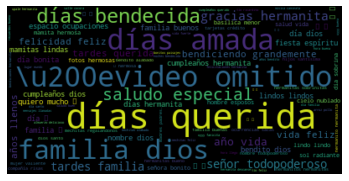

None

In [122]:
diccio_coloc={}
for name,freq in countsad1.values:
    diccio_coloc[name]=freq

nube.generate_from_frequencies(frequencies=diccio_coloc)
plt.figure()
plt.imshow(nube, interpolation="bilinear")
plt.axis("off")
figure8=plt.show()
display(figure8)

Como conclusión, se identifico que el grupo familiar se encuentra lleno de saludos, y mensajes positivos hacia la familia y Dios. 